# Install packages

In [ ]:
pip install geopandas

# Load packages

In [ ]:
import pandas as pd
import os
import sys
import math
import numpy as np
import ast
import geopandas as gpd

from urllib.request import urlopen
from zipfile import ZipFile

import requests
from io import StringIO

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter

from shapely.geometry import Point

# Load tracts and counties shapefiles

If you need to link to you Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# go go the working directory
% cd /content/drive/MyDrive/Research/segregation

Mounted at /content/drive
/content/drive/MyDrive/Research/segregation


In [ ]:
plt.rcParams['figure.figsize'] = (15, 12) #set default figure size

# shapefile_url = r'https://github.com/GIBDUSC/Twitter-derived-human-mobility/raw/master/sc_tract.zip'

# North American Equidistance conic:  +proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs

shapefile_url = r'/content/drive/MyDrive/Research/Homophily/tract_shape.zip'
tract_gdf = gpd.read_file(shapefile_url)    #.to_crs('EPSG:6569')   # EPSG:6569:  NAD83(2011) / South Carolina


us_tract_gdf = tract_gdf.to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
us_tract_gdf

,Tract,SUM_ALAND,SUM_AWATER,geometry
0,01001020100,9817812.0,28435.0,"POLYGON ((849842.032 -790235.252, 849845.968 -..."
1,01001020200,3325679.0,5670.0,"POLYGON ((850128.923 -788873.943, 850158.687 -..."
2,01001020300,5349273.0,9054.0,"POLYGON ((852124.442 -788357.613, 852135.569 -..."
3,01001020400,6384276.0,8408.0,"POLYGON ((852675.039 -788119.710, 852708.737 -..."
4,01001020500,11408873.0,43534.0,"POLYGON ((856103.028 -790334.738, 856134.238 -..."
...,...,...,...,...
74128,78030960900,8151330.0,3040065.0,"MULTIPOLYGON (((3261872.472 -1848606.600, 3261..."
74129,78030961000,2105264.0,2358459.0,"POLYGON ((3248773.659 -1839714.021, 3248908.96..."
74130,78030961100,3513674.0,0.0,"POLYGON ((3252066.050 -1838979.433, 3252093.41..."
74131,78030961200,1017753.0,802134.0,"POLYGON ((3249665.327 -1839294.414, 3249782.60..."


# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# us_tract_gdf.plot()

Coordinate systems: epsg:4326
Len(county_gdf): 3221


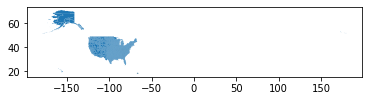

In [ ]:
shapefile_url = r'https://github.com/GIBDUSC/test/raw/master/us_counties.zip'

# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", us_county_gdf.crs)
print(f"Len(county_gdf): {len(us_county_gdf)}")
us_county_gdf.count

us_county_gdf['fips'] = us_county_gdf['FIPS'].str[2:]
# county_gdf =  county_gdf.loc[county_gdf.STATE=="45"]
us_county_gdf.plot()

In [ ]:
us_county_gdf.head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,FIPS,fips_1,average_20,complete_2,average_48,complete_4,average_50,complete_5,average_75,complete_7,geometry,fips
0,0500000US01001,01,001,Autauga,County,594.436,US01001,US01001,16,12,20,19,20,19,9,65,"POLYGON Z ((-86.49677 32.34444 0.00000, -86.71...",01001
1,0500000US01009,01,009,Blount,County,644.776,US01009,US01009,16,14,20,15,20,15,9,73,"POLYGON Z ((-86.57780 33.76532 0.00000, -86.75...",01009


# Process each state

Find which state should be processed

In [ ]:
state_csv = r'https://raw.githubusercontent.com/gladcolor/homophily/master/state_code.csv'
state_df = pd.read_csv(state_csv, dtype=str)
state_df.columns = ['State_Name', 'State_Abbreviation', 'State_FIPS']
us_county_gdf = us_county_gdf.merge(state_df, left_on='STATE', right_on='State_FIPS')

state_codes =  us_county_gdf['STATE'].unique() 

print("To process state code count: ", len(state_codes))
print(us_county_gdf['State_Name'].unique())

To process state code count:  52
['Alabama' 'Arkansas' 'California' 'Colorado' 'Florida' 'Georgia'
 'Connecticut' 'Arizona' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Minnesota' 'Mississippi' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Jersey' 'New Mexico' 'North Carolina' 'Ohio' 'Oklahoma'
 'North Dakota' 'New York' 'Pennsylvania' 'South Carolina' 'Tennessee'
 'South Dakota' 'Oregon' 'Texas' 'Utah' 'Virginia' 'Washington'
 'Wisconsin' 'Wyoming' 'West Virginia' 'Vermont' 'Delaware'
 'District of Columbia' 'New Hampshire' 'Rhode Island' 'Alaska' 'Hawaii'
 'Puerto Rico']


## Define functions to compute segregation index

In [ ]:
def calculate_dissimilarity(df):
    result =   (df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum'] - df['White'] / df['WhiteSum']).abs().sum() * 0.5
    return result

def calculate_isolation(df):
    # zero_idx = df['TotalPopulation'] == 0
    # if zero_idx.sum() > 0:
        # df.loc[zero_idx, 'TotalPopulation'] = 1
        # print(df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'White', 'BlackAfricanAmerican', 'TotalPopulation']])
        # print(f"When commputing Isolation Index, found  above {zero_idx.sum()} TotalPopulation = 0, have set TotalPopulation = 1 to avoid 'divided by zero'.")

    # Not used
    # result = ((df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum']) * (df['White'] / df['TotalPopulation'])).sum()
    #                    m_i                            sum(m_i)      r_i (white: reference)      t_i = r_i + m_i

    result = ((df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum']) * (df['BlackAfricanAmerican'] / df['TotalPopulation'])).sum()

    return result

def calculate_delta(df):
    result = (df['BlackAfricanAmerican'] / df['BlackAfricanAmericanSum'] - df['AreaTotal'] / df['AreaTotalSum']).abs().sum() * 0.5
    return result

# do not understand yet. Huan
def calculate_centralization0(df):
    df = df.sort_values("AreaTotal").reset_index()
    N = len(df)
    sum_m_i = 0
    sum_m_i_1 = 0
    # print(df)
    for i in range(1, N):
        m_i = df.at[i, 'BlackAfricanAmerican']
        m_i_1 = df.at[i - 1, 'BlackAfricanAmerican']

        a_i = df.at[i, 'AreaTotal']
        a_i_1 = df.at[i - 1, 'AreaTotal']

        sum_m_i += m_i_1 * a_i
        sum_m_i_1 += m_i * a_i_1
    
    ACI = sum_m_i - sum_m_i_1

    return ACI

# compute the cumulated ratio
def get_relative_centralization(df, method='relative'):
    # method is in ['relative', 'absolute']
    # df is sorted.
    RCI_sum1 = 0
    RCI_sum2 = 0
    ACI_sum1 = 0
    ACI_sum2 = 0
    # print(len(df))
    assert method in ['relative', 'absolute']
    
    for j in range(1, len(df)):   # X: black, Y: white
        X_j_1 = df.loc[j-1, 'Black_to_CBD_dis_cum']
        X_j   = df.loc[j,   'Black_to_CBD_dis_cum']
        Y_j_1 = df.loc[j-1, 'White_to_CBD_dis_cum']
        Y_j   = df.loc[j,   'White_to_CBD_dis_cum']
        A_j   = df.loc[j,   'Area_cum']
        A_j_1 = df.loc[j,   'Area_cum']
        
        RCI_sum1 += X_j_1 * Y_j
        RCI_sum2 += X_j   * Y_j_1

        ACI_sum1 = X_j_1 * A_j
        ACI_sum2 = X_j   * A_j_1

    RCI = RCI_sum1 - RCI_sum2
    ACI = ACI_sum1 - ACI_sum2
    if method == 'relative':
        return RCI    
    if method == 'absolute':
        return ACI    


def calculate_centralization(county_df, method='relative'):
    county_df = county_df.sort_values('distance_to_CBD').reset_index()

    county_df.loc[:, 'Whitesum'] = county_df['White'].sum()
    county_df.loc[:, 'White_to_CBD_dis_cum'] = county_df['White'].cumsum() / county_df['Whitesum']

    county_df.loc[:, 'Blacksum'] = county_df['BlackAfricanAmerican'].sum()
    county_df.loc[:, 'Black_to_CBD_dis_cum'] = county_df['BlackAfricanAmerican'].cumsum() / county_df['Blacksum']

    county_df.loc[:, 'Area_cum'] = county_df['AreaTotal'].cumsum() / county_df['AreaTotalSum']

    county_df.loc[:, 'relative_centralization'] = get_relative_centralization(county_df)
    
    RCI = get_relative_centralization(county_df, method=method)
 
    return RCI


def calculate_absolute_centralization(county_df):
    ACI = calculate_centralization(county_df, method='absolute')
    return ACI

def calculate_proximity(df): 
    """
    df: all Census tracts of a county
    """
    df = df.reset_index()
    N = len(df)
    # print((df))
    Pxx = 0
    Prr = 0
    Ptt = 0
    
    for i in range(N):  # for every i (a Census tract)
        a_i = df.at[i, 'AreaTotal']     # area of a tract i
        e_exp_i = math.sqrt(0.6 * a_i)
        d_ii = e_exp_i

        m_i = df.at[i, 'BlackAfricanAmerican']     # minority population (Black) of tract i
        M = df.at[i, 'BlackAfricanAmericanSum']    # sum of minority population in this county
        
        r_i = df.at[i, 'White']    # reference population  (White) of tract i
        R = df.at[i, 'WhiteSum']    # sum of reference population in this county

        t_i = df.at[i, 'TotalPopulation']  # population of tract i
        T = df.at[i, 'TotalPopulationSum']   # sum of total population in this county
        

        # for j in range(i, N):   # Do not get the same result as range(N). 
        for j in range(N):   # for every j (a Census tract)  
            # for every pair of i, j (two Census tracts)
            a_j = df.at[j, 'AreaTotal']     # area of a tract j
            e_exp_j = math.sqrt(0.6 * a_j)
            d_jj = e_exp_j

            d_ij = d_ii + d_jj

            c_ij = math.exp(-d_ij)

            m_j = df.at[j, 'BlackAfricanAmerican']     # minority population (Black) of tract j
            Pxx += m_i * m_j *  c_ij / M**2

            r_j = df.at[j, 'White']     # reference population  (White) of tract j
            Prr += r_i * r_j * c_ij / R**2

            t_j = df.at[j, 'TotalPopulation']     # population of  tract j
            Ptt += t_i * t_j * c_ij / T**2
    
    SPI = (M * Pxx*2 + R * Prr*2) / (T * Ptt*2)
    
    return SPI

## Load population data test



In [ ]:
def load_year_data(year):

    year_list = ["2009-2013", "2010-2014", "2011-2015", "2012-2016", "2013-2017", "2014-2018", "2015-2019"]

    assert(year in year_list), f"Year is not in {year_list}."
    census = f'https://github.com/gladcolor/segregation_index/raw/master/data_us_tract/{year}.zip'

    us_tract_pop_df = pd.read_csv(census)
    if us_tract_pop_df.columns[0] != "FIPS":
        us_tract_pop_df = us_tract_pop_df.iloc[:, 1:] 
    row_cnt_has_na = len(us_tract_pop_df)

    us_tract_pop_df = us_tract_pop_df.dropna()
    row_cnt_na = row_cnt_has_na - len(us_tract_pop_df)

    print(f"Loading data, year: {year}")

    us_tract_pop_df.loc[:, 'CountyFIPS'] = us_tract_pop_df['CountyFIPS'].astype(float).astype(int).astype(str).str.zfill(5)
    # print(us_tract_pop_df.dtypes)
    us_tract_pop_df.loc[:, 'Tract_FIPS'] = us_tract_pop_df['FIPS'].astype(str).str.zfill(11)

    print(f'Found rows: {len(us_tract_pop_df)}, after removing {row_cnt_na} nan row(s).')

    zero_idx = (us_tract_pop_df['TotalPopulation'] == 0)  
    if zero_idx.sum() > 0:  
        print(us_tract_pop_df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'White', 'BlackAfricanAmerican', 'TotalPopulation']])
        # us_tract_pop_df.loc[zero_idx, 'BlackAfricanAmerican'] = 1
        print()
        us_tract_pop_df = us_tract_pop_df[~zero_idx]
        print(f"Found above {zero_idx.sum()} rows that TotalPopulation number == 0, have dropped them.\n")

    # if a value == 0, make it == 1, to avoid divided by zero.
    zero_idx = (us_tract_pop_df['White'] == 0)    
    if zero_idx.sum() > 0:
        print(us_tract_pop_df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'White']])
        # us_tract_pop_df.loc[zero_idx, 'White'] = 1
        print()
        print(f"Found above {zero_idx.sum()} rows that White number == 0, have set it to 1 to avoid 'divded by zero'.")


    zero_idx = (us_tract_pop_df['BlackAfricanAmerican'] == 0 ) 
    if zero_idx.sum() > 0:  
        print(us_tract_pop_df.loc[zero_idx, ['FIPS', 'CountyFIPS', 'StateAbbreviation', 'BlackAfricanAmerican']])
        # us_tract_pop_df.loc[zero_idx, 'BlackAfricanAmerican'] = 1
        print()
        print(f"Found above {zero_idx.sum()} rows that BlackAfricanAmerican number == 0, have set it to 1 to avoid 'divded by zero'.\n")



    # zero_idx = us_tract_pop_df['Asian'] == 0    
    # us_tract_pop_df.loc[zero_idx, 'Asian'] = 1
    print()

    return us_tract_pop_df


# year = "2009-2013"
# year = "2010-2014"
# year = "2011-2015"
#year = "2012-2016"
#year = "2013-2017"
# year = "2014-2018"
year = "2015-2019"

us_tract_pop_df = load_year_data(year)
us_tract_pop_df.sample(2)

Loading data, year: 2015-2019
Found rows: 74001, after removing 0 nan row(s).
              FIPS CountyFIPS  ... BlackAfricanAmerican  TotalPopulation
43      1003990000      01003  ...                    0                0
106     1015981901      01015  ...                    0                0
107     1015981902      01015  ...                    0                0
108     1015981903      01015  ...                    0                0
868     1097990000      01097  ...                    0                0
...            ...        ...  ...                  ...              ...
73926  72137990000      72137  ...                    0                0
73957  72143990000      72143  ...                    0                0
73971  72145990000      72145  ...                    0                0
73974  72147990000      72147  ...                    0                0
73989  72151990000      72151  ...                    0                0

[703 rows x 6 columns]

Found above 703 rows 

,FIPS,CountyFIPS,StateAbbreviation,AreaTotal,TotalPopulation,White,BlackAfricanAmerican,AmericanIndianAlaskaNative,Asian,NativeHawaiianOtherPacificIslander,SomeOtherRace,TwoOrMoreRaces,Tract_FIPS
32682,25027757300,25027,MA,0.367841,2651,1979,180,19,8,0,328,137,25027757300
41754,34021003301,34021,NJ,4.622415,6863,6051,265,0,365,0,21,161,34021003301


## Download all state tract polygons

Needs about 5 minutes, then project them into an equidistance projection.

In [ ]:
def download_state_tract_gdf(state_codes):
    state_tract_gdf_dict = {}
    for state_code in state_codes:
        
        state_csv = f'https://github.com/gladcolor/segregation_index/raw/master/us_tract_shp/tract_shp_{state_code}.zip'
        equidistance_crs = r'+proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs'
        # North American Equidistance conic:  +proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs
        state_gdf = gpd.read_file(state_csv).to_crs(equidistance_crs)
        state_tract_gdf_dict[state_code] = state_gdf
        print(f"Processed state code: {state_code}, got tract polygon records: {len(state_gdf)}")
    return state_tract_gdf_dict

state_codes =  us_county_gdf['STATE'].unique()

state_tract_gdf_dict = download_state_tract_gdf(state_codes)    

Processed state code: 01, got tract polygon records: 1181
Processed state code: 05, got tract polygon records: 686
Processed state code: 06, got tract polygon records: 8057
Processed state code: 08, got tract polygon records: 1249
Processed state code: 12, got tract polygon records: 4245
Processed state code: 13, got tract polygon records: 1969
Processed state code: 09, got tract polygon records: 833
Processed state code: 04, got tract polygon records: 1526
Processed state code: 16, got tract polygon records: 298
Processed state code: 17, got tract polygon records: 3123
Processed state code: 18, got tract polygon records: 1511
Processed state code: 19, got tract polygon records: 825
Processed state code: 20, got tract polygon records: 770
Processed state code: 21, got tract polygon records: 1115
Processed state code: 22, got tract polygon records: 1148
Processed state code: 27, got tract polygon records: 1338
Processed state code: 28, got tract polygon records: 664
Processed state code

## Compute indices (20 minitues per year)


In [ ]:
# define a visualization function
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_indices(result_gdf, indices_functions, fig_name):
    state_name = result_gdf.loc[0, 'State_Name']
    ax_row_cnt = 2
    ax_col_cnt = 3
    fig, axs = plt.subplots(2, 3, figsize=(20, 14))
    # plt.tight_layout()

    for idx, key in enumerate(indices_functions.keys()):
        ax_row = int(idx / ax_col_cnt)
        ax_col = idx - ax_row * ax_col_cnt
        ax = axs[ax_row, ax_col]
        ax.axis("off")
        ax.set_title(key)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="7%", pad=0.1)
        # equal_area_crs = 2163 # North America Albers Equal Area Conic
        lon_0 = result_gdf.to_crs(4326).centroid.x.mean()  # central lon
        lat_0 = result_gdf.to_crs(4326).centroid.y.mean()   # central lon
        # print('lon_0:', lon_0)
        # local_crs = f'+proj=tmerc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0={lon_0} +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs' 
        local_crs = f'+proj=tmerc +lat_0={lat_0} +lon_0={lon_0} +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

        missing_kwds = dict(color='grey', label='No Data') # about 100 counties have no black.

        # i = result_gdf[key].isna()
        # print("Missing values:", result_gdf[i])

        result_gdf.to_crs(local_crs).plot(
                                    ax=ax,
                                    column=key, 
                                    missing_kwds=missing_kwds, 
                                    cmap='Reds', 
                                    # legend_kwds={'orientation':'vertical',"label": key},
                                    legend=True,   
                                    cax=cax
                                    )

    
    year = fig_name.split('_')[1][:-4]
    tile = f'{state_name} Segeregation Indices ({year})'
    fig.suptitle(tile, fontsize=24)
    plt.savefig(fig_name)
    print(f'Saved figure in {fig_name}')
        # plt.show()

    return plt


In [ ]:
# Turn off pandas warning
pd.options.mode.chained_assignment = None  # default='warn'  

import warnings
warnings.filterwarnings("ignore")

# Determine which index needs to be computed.
indices_functions = {
                    "Spatial_Proximity ":calculate_proximity,
                    "Dissimilarity":calculate_dissimilarity,
                    "Isolation ":calculate_isolation,
                    "Delta":calculate_delta,
                    "Absolute_Centralization":calculate_absolute_centralization,
                    "Relative_Centralization":calculate_centralization,
                    }

# compute index for a geopandas dataframe.
def compute_AOI_index(AOI_tract_gdf, AOI_county_gdf, AOI_tract_pop_df):
    
    # Aggregate dataframe
    AOI_pop_county_df = AOI_tract_pop_df.groupby(['CountyFIPS']).agg(AreaTotalSum=('AreaTotal','sum'),
                                           TotalPopulationSum=('TotalPopulation','sum'),
                                           WhiteSum=('White','sum'),
                                           BlackAfricanAmericanSum=('BlackAfricanAmerican','sum')
                                          )

    
    AOI_tract_pop_county_df = pd.merge(AOI_tract_pop_df, AOI_pop_county_df, left_on='CountyFIPS', right_on="CountyFIPS", how="left")

    merged_CBD_gdf = compute_CDB_distance_rank(AOI_tract_pop_county_df, AOI_tract_gdf)


    indices_functions = {
                    "Spatial_Proximity ":calculate_proximity,
                    "Dissimilarity":calculate_dissimilarity,
                    "Isolation ":calculate_isolation,
                    "Delta":calculate_delta,
                    "Absolute_Centralization":calculate_absolute_centralization,
                    "Relative_Centralization":calculate_centralization,
                    }

    result_df_list = [] # put the results here

    for key in indices_functions.keys():

        print("Calculating index of:", key)

        result_df = merged_CBD_gdf.groupby(['CountyFIPS']).apply(
            indices_functions[key]   
        ).reset_index(name=key)  #  name=key


        result_df.loc[:, 'CountyFIPS'] = result_df['CountyFIPS'].astype(str)
        #county_gdf['fips'] = county_gdf['fips'].astype(str)
        result_df_list.append(result_df)

    # merge the results
    results_all_df = pd.DataFrame()
    results_all_df.loc[:,'CountyFIPS'] = result_df.iloc[:, 0]
    for df in result_df_list:
        column_name = df.columns[1]
        results_all_df[column_name] = df.loc[:, column_name]
        

    # merged_CBD_gdf.plot(column='distance_to_CBD', legend=True)
    # fig, ax = plt.subplots(figsize=(15, 15))
    # tract_gdf.plot(ax=ax)
    # CBD_gdf.plot(ax=ax, color='r')
    

    return results_all_df

# calculate distances to CBD.
def get_distance_to_CDB(df):
    delta_x = df['tract_center_x'] - df['cbd_center_x']
    delta_y = df['tract_center_y'] - df['cbd_center_y']
    distance = (delta_x**2 + delta_y**2)**0.5
    return distance


# Calculate CDB and distances to the CDB
def compute_CDB_distance_rank(AOI_tract_pop_county_df, AOI_tract_gdf):                     
    AOI_tract_pop_county_df.loc[:, 'pop_density'] = AOI_tract_pop_county_df['TotalPopulation']  / AOI_tract_pop_county_df['AreaTotal']
    AOI_tract_pop_county_df.loc[:, 'pop_density_rank'] = AOI_tract_pop_county_df.groupby(['CountyFIPS'])['pop_density'].rank('dense', ascending=False).astype(int)
    AOI_tract_pop_county_df.loc[:, 'pop_rank'] = AOI_tract_pop_county_df.groupby(['CountyFIPS'])['TotalPopulation'].rank('dense', ascending=False).astype(int)

    AOI_tract_pop_county_df.loc[:, 'FIPS'] = AOI_tract_pop_county_df['FIPS'].astype(str).str.zfill(11)

    # Cannot find boundaries for all CDB, so we temporarily define CBD as top 1 highest population tract of in a county.
    merged_gdf = AOI_tract_gdf.merge(AOI_tract_pop_county_df, how='left', left_on='Tract_FIPS', right_on='FIPS').dropna()
    merged_gdf.loc[:, 'tract_center_x'] = merged_gdf.centroid.x
    merged_gdf.loc[:, 'tract_center_y'] = merged_gdf.centroid.y

    CBD_gdf = merged_gdf[merged_gdf['pop_rank'] == 1]
    CBD_gdf.loc[:, 'cbd_center_x'] = CBD_gdf.centroid.x
    CBD_gdf.loc[:, 'cbd_center_y'] = CBD_gdf.centroid.y
    CBD_gdf.loc[:, 'CBD_FIPS'] = CBD_gdf['FIPS']

    merged_CBD_gdf = merged_gdf.merge(CBD_gdf[['CountyFIPS', 'CBD_FIPS', 'cbd_center_x', 'cbd_center_y']], how='left', left_on='CountyFIPS', right_on='CountyFIPS').dropna()

    merged_CBD_gdf.loc[:, 'distance_to_CBD'] = merged_CBD_gdf.apply(get_distance_to_CDB, axis=1)
    merged_CBD_gdf.loc[:, 'ditance_to_CBD_rank'] = merged_CBD_gdf.groupby(['CountyFIPS'])['distance_to_CBD'].rank('dense', ascending=True).astype(int)

    return merged_CBD_gdf


def get_state_tract_gdf(state_code):
    state_csv = f'https://github.com/gladcolor/segregation_index/raw/master/us_tract_shp/tract_shp_{state_code}.zip'
    state_gdf = gpd.read_file(state_csv)
    return state_gdf


# Process each state

def compute_US_index(us_tract_pop_df, year):

    result_df_list = []
    for idx, state_code in enumerate(state_codes[:]):

        state_name = state_df.loc[state_df['State_FIPS'] == state_code, 'State_Name'].iloc[0]

        print(f'Processing year {year}, # {idx + 1} /  {len(state_codes)}, {state_name}, state_code: {state_code}')
        
        # AOI_tract_gdf = us_tract_gdf[us_tract_gdf['Tract'].str[:2] == state_code]
        AOI_tract_gdf = state_tract_gdf_dict[state_code]
        AOI_tract_gdf.loc[:, 'Tract_FIPS'] = AOI_tract_gdf['Tract']
        AOI_county_gdf = us_county_gdf[us_county_gdf['fips'].str[:2] == state_code]
        AOI_tract_pop_df =  us_tract_pop_df[us_tract_pop_df['Tract_FIPS'].str[:2] == state_code]    
        

        
        total_pop = AOI_tract_pop_df['TotalPopulation'].sum()
        print(f'County count: {len(AOI_county_gdf)}, tract count: {len(AOI_tract_gdf)}, AOI population: {total_pop}')

        
        
        result_df = compute_AOI_index(AOI_tract_gdf, AOI_county_gdf, AOI_tract_pop_df)
        result_df = result_df.merge(AOI_county_gdf[['fips']], left_on='CountyFIPS', right_on='fips', how='left').drop(columns=['fips'])
        result_df_list.append(result_df)
        result_df.to_csv(state_name + f'_{year}_segregation_index.csv', index=False)
        result_gdf = pd.merge(AOI_county_gdf, result_df, left_on='fips', right_on="CountyFIPS")
        fig_name = state_name + f'_{year}.png'
        # print('fig_name in compute_US_index():', fig_name)
        plt = visualize_indices(result_gdf, indices_functions, fig_name=fig_name)
        plt.show()

        print('-' * 100)

    print("Merging: ")
    year_all_state_df = pd.concat(result_df_list, axis=0)


    year_all_state_df['CountyFIPS'] = year_all_state_df['CountyFIPS'].astype(str).str.zfill(5)

    year_all_state_df = year_all_state_df.merge(county_name_df, how="left", left_on="CountyFIPS", right_on='fips').drop(columns='fips')

    year_all_state_df.to_csv(f"US_{year}_segregation_index.csv", index=False)

# Which year needs to be processed.
year_list = ["2009-2013", "2010-2014", "2011-2015", "2012-2016", "2013-2017", "2014-2018", "2015-2019"]


# process each year. A year needs about 20 minutes.
for year in year_list:    
    print(f"Working on: year {year}")
    us_tract_pop_df = load_year_data(year)

    compute_US_index(us_tract_pop_df, year )



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
result_df_list

Not used...

 Compute and visualize the Indices


Calculating index of :  Spatial_Proximity 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Calculating index of :  Dissimilarity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Calculating index of :  Isolation 
Calculating index of :  Delta
Calculating index of :  Absolute_Centralization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


Calculating index of :  Relative_Centralization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


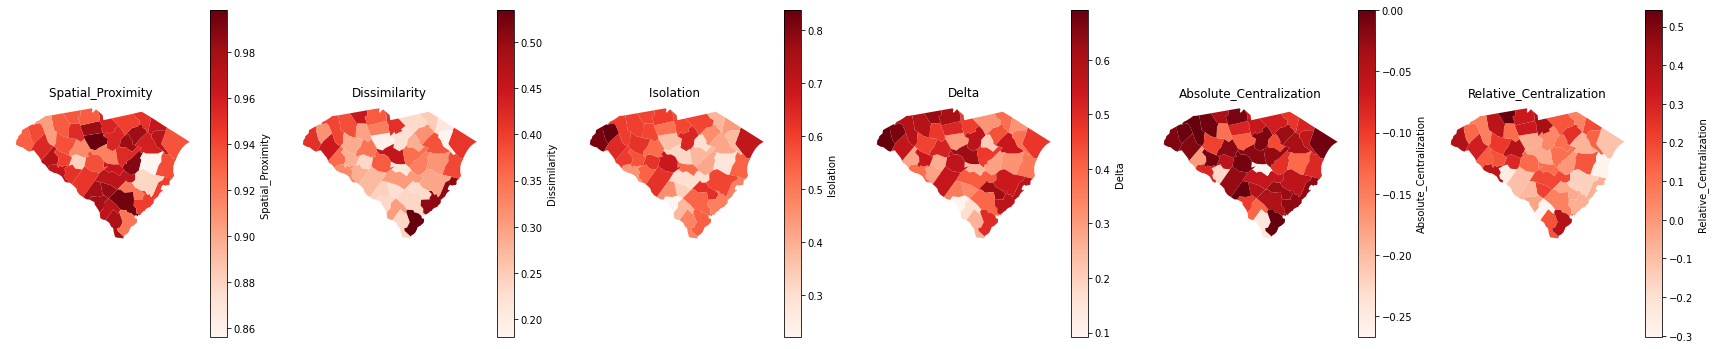

In [ ]:
df_sc = merged_CBD_gdf




# Zhenlong
# diss = df_sc.groupby(['CountyFIPS'])["White", "BlackAfricanAmerican","WhiteSum", "BlackAfricanAmericanSum"].apply(
#     lambda x : 0.5*abs(x.BlackAfricanAmerican/x.BlackAfricanAmericanSum - x.White/x.WhiteSum).sum()
# ).reset_index(name='Dissimilarity')



fig, axs = plt.subplots(1, len(indices_functions.keys()), figsize=(30, 6))


def calculate_indices():
    i = 0
    for key in indices_functions.keys():

        print("Calculating index of : ", key)

        result_df = df_sc.groupby(['CountyFIPS']).apply(
            indices_functions[key]   
        ).reset_index(name=key)  #  name=key


        result_df['CountyFIPS'] = result_df['CountyFIPS'].astype(str)
        county_gdf['fips'] = county_gdf['fips'].astype(str)

        # EPSG:2163, US National Atlas Equal Area
        # WGS84 Bounds: -66.0200, 15.3200, 168.3300, 74.7900
        # Projected Bounds: -8040784.5135, -2577524.9210, 3668901.4484, 4785105.1096

        # ax.set_xlim([-2400000,  2640000])
        # ax.set_ylim([-2400000, 1000000])

        joined_gdf = pd.merge(county_gdf, result_df, left_on='fips', right_on="CountyFIPS")
        ax = axs[i]
        ax.axis("off")
        ax.set_title(key)
        joined_gdf.to_crs(2163).plot(ax=ax,
                                    column=key, 
                                    #  vmin=0, 
                                    #  vmax=0.6, 
                                    cmap='Reds', 
                                    legend_kwds={'orientation':'vertical',"label": key},
                                    legend=True,                                   
                                    # figsize=(20, 4)).axis("off"),

                                    )

        saved_path = r'/content/drive/MyDrive/Research/segregation'
        if not os.path.exists(saved_path):
            os.makedirs(saved_path)

        new_name = os.path.join(saved_path, "segeration_" + key + ".shp")

        joined_gdf.to_file(new_name)
        i += 1

    return joined_gdf

joined_gdf = calculate_indices()


# Tools

## Split tract files

In [ ]:
shapefile_url = r'/content/drive/MyDrive/Research/Homophily/tract_shape.zip'
tract_gdf = gpd.read_file(shapefile_url)    #.to_crs('EPSG:6569')   # EPSG:6569:  NAD83(2011) / South Carolina

# North American Equidistance conic:  +proj=eqdc +lat_0=0 +lon_0=0 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs

# us_tract_gdf = tract_gdf.to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate system:", tract_gdf.crs)

Coordinate system: epsg:4269


In [ ]:

# shapefile_url = r'https://github.com/GIBDUSC/Twitter-derived-human-mobility/raw/master/sc_tract.zip'
us_tract_gdf['state_code'] = us_tract_gdf['Tract'].str[:2]
us_tract_gdf

,Tract,SUM_ALAND,SUM_AWATER,geometry,state_code
0,01001020100,9817812.0,28435.0,"POLYGON ((849842.032 -790235.252, 849845.968 -...",01
1,01001020200,3325679.0,5670.0,"POLYGON ((850128.923 -788873.943, 850158.687 -...",01
2,01001020300,5349273.0,9054.0,"POLYGON ((852124.442 -788357.613, 852135.569 -...",01
3,01001020400,6384276.0,8408.0,"POLYGON ((852675.039 -788119.710, 852708.737 -...",01
4,01001020500,11408873.0,43534.0,"POLYGON ((856103.028 -790334.738, 856134.238 -...",01
...,...,...,...,...,...
74128,78030960900,8151330.0,3040065.0,"MULTIPOLYGON (((3261872.472 -1848606.600, 3261...",78
74129,78030961000,2105264.0,2358459.0,"POLYGON ((3248773.659 -1839714.021, 3248908.96...",78
74130,78030961100,3513674.0,0.0,"POLYGON ((3252066.050 -1838979.433, 3252093.41...",78
74131,78030961200,1017753.0,802134.0,"POLYGON ((3249665.327 -1839294.414, 3249782.60...",78


In [ ]:
import shutil


print("Start to split gdf to small shape files then zip them...")

cwd = os.getcwd()
print("Current working directory:", cwd)
state_codes = us_tract_gdf['state_code'].unique()

for idx, state_code in enumerate(state_codes):

    print(f'Processing: {idx + 1} / {len(state_codes)}, state code: {state_code}')
    zip_dir = os.path.join(cwd, state_code)
    os.makedirs(zip_dir, exist_ok = True)

    print(f'    Create zip file directory: {zip_dir}')
    # state_gdf = us_tract_gdf[us_tract_gdf['state_code'] == state_code]
    print(f'    Found {len(state_gdf)} tracts in the state: {state_code}')


    state_file_name = os.path.join(zip_dir, f'tract_{state_code}.shp')
    state_gdf.to_file(state_file_name)

    zipped_file_name = os.path.join(os.path.dirname(zip_dir), f'tract_shp_{state_code}')

    print('zipped_file_name:', zipped_file_name)

    shutil.make_archive(zipped_file_name, 'zip', zip_dir)


Start to split gdf to small shape files then zip them...
Current working directory: /content/drive/My Drive/Research/segregation
Processing: 1 / 56, state code: 01
    Create zip file directory: /content/drive/My Drive/Research/segregation/01
    Found 1181 tracts in the state: 01
zipped_file_name: /content/drive/My Drive/Research/segregation/tract_shp_01
Processing: 2 / 56, state code: 02
    Create zip file directory: /content/drive/My Drive/Research/segregation/02
    Found 1181 tracts in the state: 02
zipped_file_name: /content/drive/My Drive/Research/segregation/tract_shp_02
Processing: 3 / 56, state code: 04
    Create zip file directory: /content/drive/My Drive/Research/segregation/04
    Found 1181 tracts in the state: 04
zipped_file_name: /content/drive/My Drive/Research/segregation/tract_shp_04
Processing: 4 / 56, state code: 05
    Create zip file directory: /content/drive/My Drive/Research/segregation/05
    Found 1181 tracts in the state: 05
zipped_file_name: /content/driv

## Merge state index 

In [ ]:
import glob
import os
import pandas as pd

shapefile_url = r'https://github.com/GIBDUSC/test/raw/master/us_counties.zip'

# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", us_county_gdf.crs)
print(f"Len(county_gdf): {len(us_county_gdf)}")
us_county_gdf.count

us_county_gdf['fips'] = us_county_gdf['FIPS'].str[2:]

state_csv = r'https://raw.githubusercontent.com/gladcolor/homophily/master/state_code.csv'
state_df = pd.read_csv(state_csv, dtype=str)
state_df.columns = ['State_Name', 'State_Abbreviation', 'State_FIPS']
us_county_gdf = us_county_gdf.merge(state_df, left_on='STATE', right_on='State_FIPS')

state_codes =  us_county_gdf['STATE'].unique() 

print("To process state code count: ", len(state_codes))
print(us_county_gdf['State_Name'].unique())
 

Coordinate systems: epsg:4326
Len(county_gdf): 3221
To process state code count:  52
['Alabama' 'Arkansas' 'California' 'Colorado' 'Florida' 'Georgia'
 'Connecticut' 'Arizona' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Minnesota' 'Mississippi' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Jersey' 'New Mexico' 'North Carolina' 'Ohio' 'Oklahoma'
 'North Dakota' 'New York' 'Pennsylvania' 'South Carolina' 'Tennessee'
 'South Dakota' 'Oregon' 'Texas' 'Utah' 'Virginia' 'Washington'
 'Wisconsin' 'Wyoming' 'West Virginia' 'Vermont' 'Delaware'
 'District of Columbia' 'New Hampshire' 'Rhode Island' 'Alaska' 'Hawaii'
 'Puerto Rico']


In [ ]:
us_county_gdf.head(1)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,FIPS,fips_1,average_20,complete_2,average_48,complete_4,average_50,complete_5,average_75,complete_7,geometry,fips,State_Name,State_Abbreviation,State_FIPS
0,0500000US01001,01,001,Autauga,County,594.436,US01001,US01001,16,12,20,19,20,19,9,65,"POLYGON Z ((-86.49677 32.34444 0.00000, -86.71...",01001,Alabama,AL,01


In [ ]:
us_county_gdf[['NAME', 'fips','State_Name','State_Abbreviation','State_FIPS']]

,NAME,fips,State_Name,State_Abbreviation,State_FIPS
0,Autauga,01001,Alabama,AL,01
1,Blount,01009,Alabama,AL,01
2,Chambers,01017,Alabama,AL,01
3,Chilton,01021,Alabama,AL,01
4,Colbert,01033,Alabama,AL,01
...,...,...,...,...,...
3216,Utuado,72141,Puerto Rico,PR,72
3217,Isabela,72071,Puerto Rico,PR,72
3218,Aguada,72003,Puerto Rico,PR,72
3219,Aibonito,72009,Puerto Rico,PR,72


In [ ]:
pip install tqdm


In [ ]:
from tqdm import tqdm
year_list = ["2009-2013", "2010-2014", "2011-2015", "2012-2016", "2013-2017", "2014-2018", "2015-2019"]

county_name_df = us_county_gdf[['NAME', 'fips','State_Name','State_Abbreviation','State_FIPS']]
for year in year_list[:]:
    state_index_csvs = glob.glob(f'*{year}*.csv')
    for csv in state_index_csvs:
        if csv.startswith("US_"):
            state_index_csvs.remove(csv)
    print("Processing: ", year)
    state_dfs = []
    for state_csv in tqdm(state_index_csvs):
        state_df = pd.read_csv(state_csv)
        state_dfs.append(state_df)

    print("Merging: ")

    year_all_state_df = pd.concat(state_dfs, axis=0)

    year_all_state_df['CountyFIPS'] = year_all_state_df['CountyFIPS'].astype(str).str.zfill(5)

    year_all_state_df = year_all_state_df.merge(county_name_df, how="left", left_on="CountyFIPS", right_on='fips').drop(columns='fips')

    year_all_state_df.to_csv(f"US_{year}_segregation_index.csv", index=False)
    


Processing:  2009-2013


100%|██████████| 52/52 [00:00<00:00, 375.63it/s]

Merging: 


Processing:  2010-2014


100%|██████████| 52/52 [00:00<00:00, 350.54it/s]

Merging: 


Processing:  2011-2015


100%|██████████| 52/52 [00:00<00:00, 370.48it/s]

Merging: 


Processing:  2012-2016


100%|██████████| 52/52 [00:00<00:00, 369.30it/s]

Merging: 


Processing:  2013-2017


100%|██████████| 52/52 [00:00<00:00, 346.56it/s]

Merging: 


Processing:  2014-2018


100%|██████████| 52/52 [00:00<00:00, 353.54it/s]

Merging: 


Processing:  2015-2019


100%|██████████| 52/52 [00:00<00:00, 379.78it/s]

Merging: 


In [ ]:
year_all_state_df

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,NAME,State_Name,State_Abbreviation,State_FIPS
0,01001,0.939413,0.248493,0.690832,0.527264,-0.048966,-0.100620,Autauga,Alabama,AL,01
1,01003,0.959022,0.412663,0.749345,0.675694,-0.019170,0.225080,Baldwin,Alabama,AL,01
2,01005,0.915311,0.181947,0.444951,0.289155,-0.127880,0.056555,Barbour,Alabama,AL,01
3,01007,0.993318,0.421894,0.667591,0.440640,-0.081372,0.440419,Bibb,Alabama,AL,01
4,01009,0.966120,0.350427,0.940869,0.428684,-0.018319,-0.042056,Blount,Alabama,AL,01
...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,0.893153,0.216408,0.828155,0.381115,-0.043646,0.100047,Vega Baja,Puerto Rico,PR,72
3216,72147,0.623969,0.189339,0.566266,0.217986,-0.714286,-0.189339,Vieques,Puerto Rico,PR,72
3217,72149,0.609087,0.278785,0.558145,0.467353,-0.009056,0.164398,Villalba,Puerto Rico,PR,72
3218,72151,0.967393,0.148237,0.182934,0.192280,-0.145090,0.081070,Yabucoa,Puerto Rico,PR,72


In [ ]:
pd.concat(state_dfs, axis=0)

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,CountyFIPS.1,Spatial_Proximity .1,Dissimilarity.1,Isolation .1,Delta.1,Absolute_Centralization.1,Relative_Centralization.1,CountyFIPS.2,Spatial_Proximity .2,Dissimilarity.2,Isolation .2,Delta.2,Absolute_Centralization.2,Relative_Centralization.2,CountyFIPS.3,Spatial_Proximity .3,Dissimilarity.3,Isolation .3,Delta.3,Absolute_Centralization.3,Relative_Centralization.3,CountyFIPS.4,Spatial_Proximity .4,Dissimilarity.4,Isolation .4,Delta.4,Absolute_Centralization.4,Relative_Centralization.4,CountyFIPS.5,Spatial_Proximity .5,Dissimilarity.5,Isolation .5,Delta.5,...,Relative_Centralization.46.1.1,CountyFIPS.47.1.1,Spatial_Proximity .47.1.1,Dissimilarity.47.1.1,Isolation .47.1.1,Delta.47.1.1,Absolute_Centralization.47.1.1,Relative_Centralization.47.1.1,CountyFIPS.48.1.1,Spatial_Proximity .48.1.1,Dissimilarity.48.1.1,Isolation .48.1.1,Delta.48.1.1,Absolute_Centralization.48.1.1,Relative_Centralization.48.1.1,CountyFIPS.49.1.1,Spatial_Proximity .49.1.1,Dissimilarity.49.1.1,Isolation .49.1.1,Delta.49.1.1,Absolute_Centralization.49.1.1,Relative_Centralization.49.1.1,CountyFIPS.50.1.1,Spatial_Proximity .50.1.1,Dissimilarity.50.1.1,Isolation .50.1.1,Delta.50.1.1,Absolute_Centralization.50.1.1,Relative_Centralization.50.1.1,CountyFIPS.51.1.1,Spatial_Proximity .51.1.1,Dissimilarity.51.1.1,Isolation .51.1.1,Delta.51.1.1,Absolute_Centralization.51.1.1,Relative_Centralization.51.1.1,NAME,State_Name,State_Abbreviation,State_FIPS
0,1001,0.948533,0.375686,0.624752,0.450222,-0.094184,-0.156937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003,0.967547,0.447022,0.741935,0.636784,-0.043309,0.023303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1005,0.964821,0.276443,0.432677,0.283899,-0.112505,0.109584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1007,0.985984,0.399241,0.665927,0.366049,-0.043346,0.425247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1009,0.961707,0.525532,0.933369,0.495518,-0.011002,-0.201523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,00nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9904,00

## show state-leve segregation

In [ ]:
!pip install geopandas
import geopandas as gpd

     |████████████████████████████████| 1.0 MB 15.3 MB/s 
     |████████████████████████████████| 6.3 MB 78.1 MB/s 
     |████████████████████████████████| 15.4 MB 57.3 MB/s 


In [ ]:
import pandas as pd
csv_file = r'https://raw.githubusercontent.com/gladcolor/segregation_index/master/US_segregation_indices/US_2015-2019_segregation_index.csv'
seg_df = pd.read_csv(csv_file)
seg_df

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,NAME,State_Name,State_Abbreviation,State_FIPS
0,1001,0.939413,0.248493,0.690832,0.527264,-0.048966,-0.100620,Autauga,Alabama,AL,1.0
1,1003,0.959022,0.412663,0.749345,0.675694,-0.019170,0.225080,Baldwin,Alabama,AL,1.0
2,1005,0.915311,0.181947,0.444951,0.289155,-0.127880,0.056555,Barbour,Alabama,AL,1.0
3,1007,0.993318,0.421894,0.667591,0.440640,-0.081372,0.440419,Bibb,Alabama,AL,1.0
4,1009,0.966120,0.350427,0.940869,0.428684,-0.018319,-0.042056,Blount,Alabama,AL,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,0.893153,0.216408,0.828155,0.381115,-0.043646,0.100047,Vega Baja,Puerto Rico,PR,72.0
3216,72147,0.623969,0.189339,0.566266,0.217986,-0.714286,-0.189339,Vieques,Puerto Rico,PR,72.0
3217,72149,0.609087,0.278785,0.558145,0.467353,-0.009056,0.164398,Villalba,Puerto Rico,PR,72.0
3218,72151,0.967393,0.148237,0.182934,0.192280,-0.145090,0.081070,Yabucoa,Puerto Rico,PR,72.0


In [ ]:
seg_df_gb = seg_df.groupby('State_Abbreviation').mean()
seg_df_gb

,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,State_FIPS
State_Abbreviation,,,,,,,,
AK,2149.357143,0.513356,0.186358,0.506401,0.382959,-0.129109,0.051374,2.0
AL,1067.000000,0.954102,0.359903,0.585728,0.480135,-0.080792,0.049245,1.0
AR,5075.000000,0.931974,0.382221,0.726507,0.597678,-0.143160,0.055066,5.0
AZ,4013.866667,0.838629,0.463003,0.759502,0.778012,-0.041093,0.070543,4.0
CA,6058.000000,0.749604,0.427302,0.673561,0.723265,-0.030934,0.066622,6.0
CO,8062.234375,0.913821,0.341302,0.825627,0.537084,-0.124799,0.054380,8.0
CT,9008.000000,0.849905,0.520677,0.667981,0.712393,-0.019488,0.034517,9.0
DC,11001.000000,0.873455,0.653943,0.198997,0.446738,-0.011194,-0.164557,11.0
DE,10003.000000,0.915072,0.384987,0.593103,0.544291,-0.010779,-0.027266,10.0


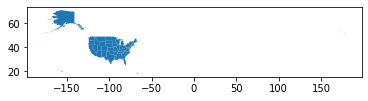

In [ ]:
state_shp = r'https://github.com/gladcolor/segregation_index/raw/master/cb_2018_us_state_20m.zip'
state_gdf = gpd.read_file(state_shp)

state_gdf.plot()

Coordinate systems: +proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
Coordinate systems: +proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs


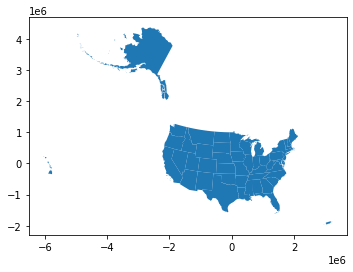

In [ ]:
# county_gdf = gpd.read_file(shapefile_url).to_crs("EPSG:2163")
# us_county_gdf = gpd.read_file(shapefile_url)# .to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", state_gdf.crs)
state_gdf = state_gdf.to_crs(r'+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
print("Coordinate systems:", state_gdf.crs)
state_gdf.plot()

In [ ]:
merged_gdf = state_gdf.set_index('STUSPS').merge(seg_df_gb, left_index=True, right_index=True)
merged_gdf.sample(2)

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,State_FIPS
KS,20,00481813,0400000US20,20,Kansas,00,211755344060,1344141205,"POLYGON ((-485356.734 16498.765, -467771.571 1...",20105.0,0.935319,0.252800,0.858257,0.505662,-0.132867,0.085296,20.0
MS,28,01779790,0400000US28,28,Mississippi,00,121533519481,3926919758,"POLYGON ((397948.194 -959278.868, 403172.971 -...",28082.0,0.968764,0.317199,0.482546,0.424733,-0.172184,0.038125,28.0


In [ ]:
merged_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 52 entries, MD to RI
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   STATEFP                  52 non-null     object  
 1   STATENS                  52 non-null     object  
 2   AFFGEOID                 52 non-null     object  
 3   GEOID                    52 non-null     object  
 4   NAME                     52 non-null     object  
 5   LSAD                     52 non-null     object  
 6   ALAND                    52 non-null     int64   
 7   AWATER                   52 non-null     int64   
 8   geometry                 52 non-null     geometry
 9   CountyFIPS               52 non-null     float64 
 10  Spatial_Proximity        52 non-null     float64 
 11  Dissimilarity            52 non-null     float64 
 12  Isolation                52 non-null     float64 
 13  Delta                    52 non-null     float64 
 14  Absolute

In [ ]:
merged_gdf.columns 

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'CountyFIPS', 'Spatial_Proximity ',
       'Dissimilarity', 'Isolation ', 'Delta', 'Absolute_Centralization',
       'Relative_Centralization', 'State_FIPS'],
      dtype='object')

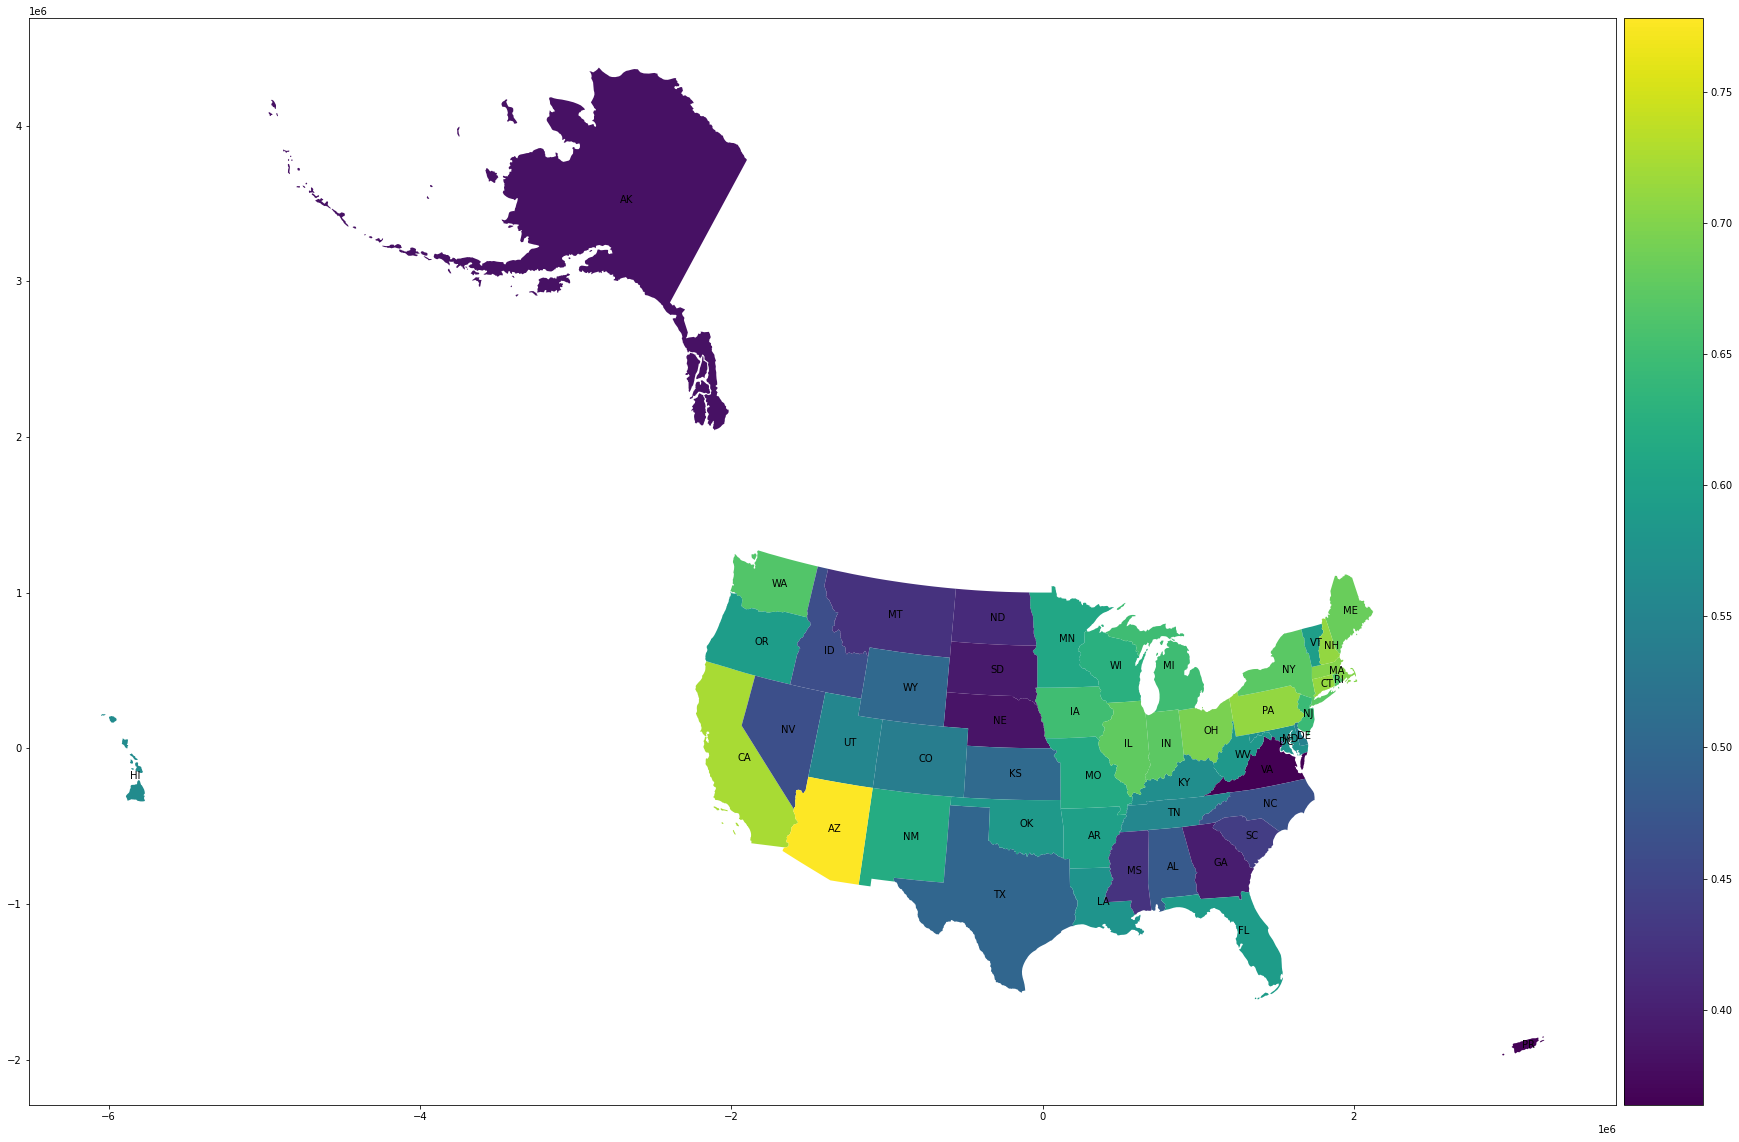

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(30, 20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

merged_gdf.plot(ax=ax, column='Delta', legend=True, cax=cax)
 

for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf.index):
    ax.annotate(label, xy=(x, y), xytext=(-3, -3), textcoords="offset points")

# plt.colorbar()

In [ ]:
merged_gdf.geometry.centroid.x

In [ ]:
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.show()

In [ ]:
merged_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,CountyFIPS,Spatial_Proximity,Dissimilarity,Isolation,Delta,Absolute_Centralization,Relative_Centralization,State_FIPS
MD,24,01714934,0400000US24,24,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((1636465.973 -38920.586, 163933...",24044.958333,0.900272,0.408929,0.603005,0.572518,-0.055796,0.060551,24.0
IA,19,01779785,0400000US19,19,Iowa,00,144661267977,1084180812,"POLYGON ((-47802.905 308831.625, -44391.317 31...",19099.000000,0.947588,0.449977,0.917710,0.651564,-0.117117,0.113242,19.0
DE,10,01779781,0400000US10,10,Delaware,00,5045925646,1399985648,"POLYGON ((1616889.791 149727.000, 1617628.486 ...",10003.000000,0.915072,0.384987,0.593103,0.544291,-0.010779,-0.027266,10.0
OH,39,01085497,0400000US39,39,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((1023660.329 262158.536, 102610...",39088.000000,0.947613,0.490214,0.834756,0.694395,-0.046923,0.084060,39.0
PA,42,01779798,0400000US42,42,Pennsylvania,00,115884442321,3394589990,"POLYGON ((1219447.613 204729.770, 1217947.950 ...",42067.000000,0.936353,0.526386,0.800433,0.710843,-0.040881,0.146058,42.0


In [ ]:
Spatial_Proximity

NameError: ignored

Dissimilarity
Isolation


KeyError: ignored

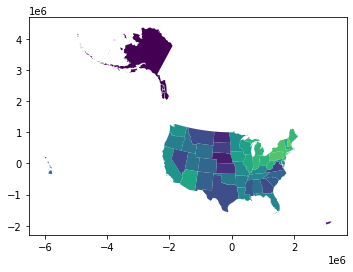

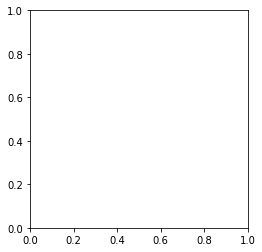

In [ ]:
idx_columns = [ 'Dissimilarity', 'Isolation', 'Delta', 'Absolute_Centralization', 'Relative_Centralization']
# 'Spatial_Proximity',
for col in idx_columns:

    print(col)
    merged_gdf.plot(column=col)